### Import Relevant Libraries

In [1]:
import geopandas as gpd # Geopandas for storing Shapely objects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata
import os
import gzip
import numpy as np
import re
import shapely
from shapely.geometry import Polygon, Point # Representing bins and cells as Shapely Polygons and Point objects
from shapely import wkt

In [2]:
import glob
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.validation import make_valid

# ====== 你的三个算法函数（需确保已定义） ======
def naive_assignment(bin_gdf, cell_gdf):
    spatial_join = gpd.sjoin(
        gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
        gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
        how="inner", predicate="within"
    )
    spatial_join["cell_id"] = spatial_join["index_right"].map(cell_gdf["cell_id"])
    genes = [col for col in bin_gdf.columns if col not in ['assigned_bin_id','row','column','geometry']]
    result = spatial_join.groupby("cell_id")[genes].sum()
    return result

def weighted_by_area(bin_gdf, cell_gdf):
    genes = [col for col in bin_gdf.columns if col not in ['assigned_bin_id','row','column','geometry']]
    spatial_join = gpd.sjoin(
        gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
        gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
        how="inner", predicate="intersects"
    )
    def safe_intersection(bin_geom, cell_geom):
        try: return bin_geom.intersection(cell_geom).area
        except: return 0
    spatial_join["overlap_area"] = spatial_join.apply(
        lambda row: safe_intersection(row["geometry"], cell_gdf.loc[row["index_right"], "geometry"]),
        axis=1
    )
    spatial_join["bin_area"] = spatial_join["geometry"].apply(lambda x: x.area)
    spatial_join["weight"] = spatial_join["overlap_area"] / spatial_join["bin_area"]
    spatial_join["cell_id"] = spatial_join["index_right"].map(cell_gdf["cell_id"])
    gene_weighted = spatial_join[genes].multiply(spatial_join["weight"], axis=0)
    gene_weighted["cell_id"] = spatial_join["cell_id"]
    res = gene_weighted.groupby("cell_id")[genes].sum()
    return res

def weighted_area_distance(bin_gdf, cell_gdf, alpha=0.01):
    genes = [col for col in bin_gdf.columns if col not in ['assigned_bin_id','row','column','geometry']]
    spatial_join = gpd.sjoin(
        gpd.GeoDataFrame(bin_gdf, geometry='geometry'),
        gpd.GeoDataFrame(cell_gdf, geometry='geometry'),
        how="inner", predicate="intersects"
    )
    spatial_join["geometry"] = spatial_join["geometry"].apply(lambda g: make_valid(g) if not g.is_valid else g)
    cell_gdf['geometry'] = cell_gdf['geometry'].apply(lambda g: make_valid(g) if not g.is_valid else g)
    def safe_intersection(bin_geom, cell_geom):
        try: return bin_geom.intersection(cell_geom).area
        except: return 0
    spatial_join["overlap_area"] = spatial_join.apply(
        lambda row: safe_intersection(row["geometry"], cell_gdf.loc[row["index_right"], "geometry"]),
        axis=1
    )
    spatial_join["bin_area"] = spatial_join["geometry"].apply(lambda x: x.area)
    spatial_join["area_weight"] = spatial_join["overlap_area"] / spatial_join["bin_area"]
    # 距离权重
    spatial_join["bin_center_x"] = spatial_join["geometry"].apply(lambda g: g.centroid.x)
    spatial_join["bin_center_y"] = spatial_join["geometry"].apply(lambda g: g.centroid.y)
    cell_gdf["centroid_x"] = cell_gdf["geometry"].apply(lambda g: g.centroid.x)
    cell_gdf["centroid_y"] = cell_gdf["geometry"].apply(lambda g: g.centroid.y)
    spatial_join["cell_center_x"] = spatial_join["index_right"].map(cell_gdf["centroid_x"])
    spatial_join["cell_center_y"] = spatial_join["index_right"].map(cell_gdf["centroid_y"])
    spatial_join["eucl_dist"] = ((spatial_join["bin_center_x"] - spatial_join["cell_center_x"])**2 + 
                                 (spatial_join["bin_center_y"] - spatial_join["cell_center_y"])**2)**0.5
    spatial_join["dist_weight"] = np.exp(-alpha * spatial_join["eucl_dist"])
    spatial_join["raw_weight"] = spatial_join["area_weight"] * spatial_join["dist_weight"]
    weight_norm = spatial_join.groupby("assigned_bin_id")["raw_weight"].transform(lambda x: x / x.sum())
    spatial_join["weight"] = weight_norm.fillna(0)
    spatial_join["cell_id"] = spatial_join["index_right"].map(cell_gdf["cell_id"])
    gene_weighted = spatial_join[genes].multiply(spatial_join["weight"], axis=0)
    gene_weighted["cell_id"] = spatial_join["cell_id"]
    res = gene_weighted.groupby("cell_id")[genes].sum()
    return res

# ====== 批量计算、容错 ======
patch_files = sorted(glob.glob("/home/wangzhuo/data/enact_synthetic_output_mousebrain/chunks/bins_gdf/patch_*.csv"))
results = []

for bin_path in patch_files:
    patch_name = bin_path.split('/')[-1]
    cell_path = bin_path.replace('bins_gdf', 'cells_gdf')
    gt_path = bin_path.replace('bins_gdf', 'ground_truth_nuclei')
    
    if not (os.path.exists(cell_path) and os.path.exists(gt_path)):
        print(f"skip {patch_name}: cells or gt missing.")
        continue
    
    try:
        bin_gdf = pd.read_csv(bin_path)
        bin_gdf['geometry'] = bin_gdf['geometry'].apply(wkt.loads)
        cell_gdf = pd.read_csv(cell_path)
        cell_gdf['geometry'] = cell_gdf['geometry'].apply(wkt.loads)
        gt = pd.read_csv(gt_path).set_index("cell_id")
        gt = gt.apply(pd.to_numeric, errors='coerce').fillna(0)
    except Exception as e:
        print(f"skip {patch_name}: {e}")
        continue
    
    if cell_gdf.empty or gt.empty:
        print(f"skip {patch_name}: no cells or ground truth")
        continue

    common_genes = list(set(bin_gdf.columns) & set(gt.columns) - set(['assigned_bin_id','row','column','geometry']))

    try:
        # Naive
        pred_naive = naive_assignment(bin_gdf, cell_gdf)
        pred1 = pred_naive.reindex(index=gt.index, columns=common_genes, fill_value=0).astype(float)
        min_sum = np.minimum(pred1.values, gt[common_genes].values).sum()
        pred_sum = pred1.values.sum()
        truth_sum = gt[common_genes].values.sum()
        pr1 = min_sum / pred_sum if pred_sum > 0 else 0
        rc1 = min_sum / truth_sum if truth_sum > 0 else 0
        f11 = 2 * pr1 * rc1 / (pr1 + rc1) if (pr1 + rc1) else 0

        # Weighted Area
        pred_wa = weighted_by_area(bin_gdf, cell_gdf)
        pred2 = pred_wa.reindex(index=gt.index, columns=common_genes, fill_value=0).astype(float)
        min_sum = np.minimum(pred2.values, gt[common_genes].values).sum()
        pred_sum = pred2.values.sum()
        pr2 = min_sum / pred_sum if pred_sum > 0 else 0
        rc2 = min_sum / truth_sum if truth_sum > 0 else 0
        f12 = 2 * pr2 * rc2 / (pr2 + rc2) if (pr2 + rc2) else 0

        # SPHERE (alpha可调)
        pred_dma = weighted_area_distance(bin_gdf, cell_gdf, alpha=0.01)
        pred3 = pred_dma.reindex(index=gt.index, columns=common_genes, fill_value=0).astype(float)
        min_sum = np.minimum(pred3.values, gt[common_genes].values).sum()
        pred_sum = pred3.values.sum()
        pr3 = min_sum / pred_sum if pred_sum > 0 else 0
        rc3 = min_sum / truth_sum if truth_sum > 0 else 0
        f13 = 2 * pr3 * rc3 / (pr3 + rc3) if (pr3 + rc3) else 0

        results.append({
            "patch": patch_name,
            "naive_precision": pr1,
            "naive_recall": rc1,
            "naive_f1": f11,
            "area_precision": pr2,
            "area_recall": rc2,
            "area_f1": f12,
            "dmaa_precision": pr3,
            "dmaa_recall": rc3,
            "dmaa_f1": f13
        })
    except Exception as e:
        print(f"skip {patch_name} in algorithm: {e}")

df = pd.DataFrame(results)
df.to_csv("patch_metrics_mousebrain.csv", index=False)
print("All finished! Results saved to patch_metrics_mousebrain.csv")

skip patch_0_0.csv: cells or gt missing.
skip patch_0_7.csv: cells or gt missing.
skip patch_10_1.csv: cells or gt missing.
skip patch_10_2.csv: cells or gt missing.
skip patch_10_3.csv in algorithm: Cannot set a DataFrame with multiple columns to the single column overlap_area
skip patch_10_4.csv: cells or gt missing.
skip patch_10_5.csv: cells or gt missing.
skip patch_10_6.csv: cells or gt missing.
skip patch_1_7.csv: cells or gt missing.
skip patch_7_7.csv: cells or gt missing.
skip patch_8_0.csv: cells or gt missing.
skip patch_8_7.csv: cells or gt missing.
skip patch_9_0.csv: cells or gt missing.
skip patch_9_7.csv: cells or gt missing.
All finished! Results saved to patch_metrics_mousebrain.csv


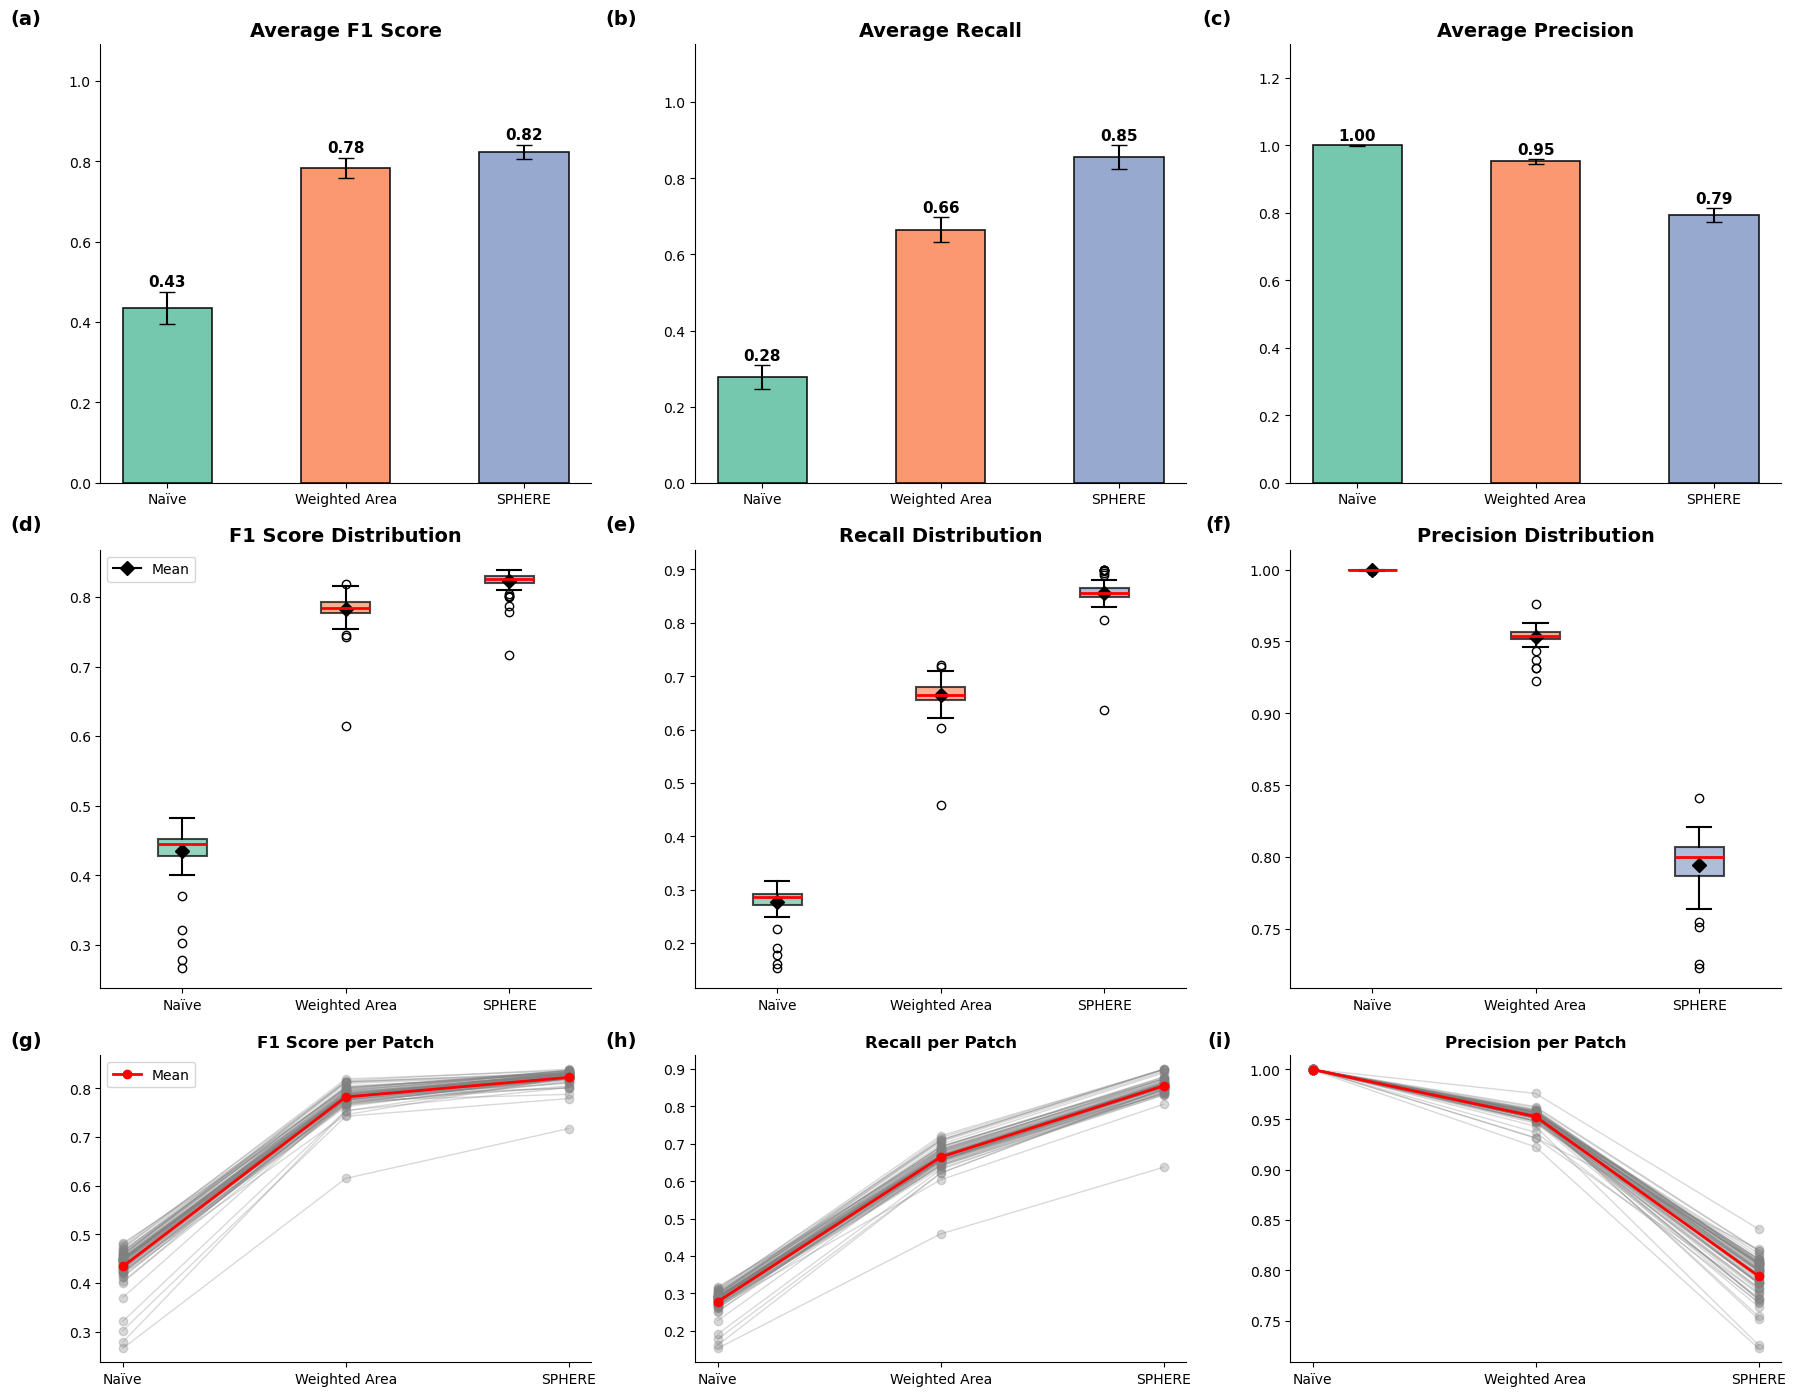

In [3]:
import glob
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import string

# 三个方法标签
methods = ["Naïve", "Weighted Area", "SPHERE"]

# 三个方法颜色
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]

# 要画的三个指标及对应的列名
metrics_info = {
    "F1 Score": ["naive_f1", "area_f1", "dmaa_f1"],
    "Recall": ["naive_recall", "area_recall", "dmaa_recall"],
    "Precision": ["naive_precision", "area_precision", "dmaa_precision"]
}

def plot_core_metrics(df, save_prefix=None):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14),
                             gridspec_kw={'height_ratios':[1, 1, 0.7]})
    subplot_labels = list(string.ascii_lowercase)
    label_idx = 0
    label_x, label_y = -0.12, 1.08

    for row_idx in range(3):
        for col_idx, (metric_name, cols) in enumerate(metrics_info.items()):
            ax = axes[row_idx, col_idx]
            data = [df[col] for col in cols]
            means = [d.mean() for d in data]
            stds  = [d.std() for d in data]

            if row_idx == 0:
                ax.bar(methods, means, yerr=stds, capsize=6, width=0.5,
                       color=colors, edgecolor='black', linewidth=1.2, alpha=0.9)
                for i, (v, s) in enumerate(zip(means, stds)):
                    ax.text(i, v + s + 0.015, f"{v:.2f}",
                            ha='center', fontsize=11, fontweight='bold')
                ax.set_ylim(0, max([m+s for m,s in zip(means, stds)]) * 1.3)
                ax.set_title(f"Average {metric_name}", fontsize=14, fontweight='bold')

            elif row_idx == 1:
                bp = ax.boxplot(
                    data, labels=methods, patch_artist=True,
                    medianprops=dict(color='red', linewidth=2),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5)
                )
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                for i, arr in enumerate(data):
                    ax.plot([i+1], [np.mean(arr)], marker='D',
                            color='black', markersize=7,
                            label='Mean' if (i == 0 and col_idx == 0) else None)
                ax.set_title(f"{metric_name} Distribution", fontsize=14, fontweight='bold')

            elif row_idx == 2:
                for _, row in df[cols].iterrows():
                    ax.plot(methods, row, marker='o', alpha=0.3,
                            color='gray', linewidth=1)
                ax.plot(methods, df[cols].mean(), marker='o',
                        color='red', linewidth=2, label='Mean')
                ax.set_title(f"{metric_name} per Patch", fontsize=12, fontweight='bold')

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if row_idx in [1, 2] and col_idx == 0:
                ax.legend()
            ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
                    transform=ax.transAxes,
                    fontsize=14, fontweight='bold', va='top', ha='right')
            label_idx += 1

    fig.tight_layout()
    if save_prefix:
        fig.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"{save_prefix}.pdf", bbox_inches="tight")
    plt.show()

# ===== 调用 =====
df = pd.read_csv("patch_metrics_mousebrain.csv")
plot_core_metrics(df, "figure2_mousebrain")

In [4]:
def plot_supplementary(df, save_prefix=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    subplot_labels = list(string.ascii_lowercase)  # a, b, c...
    label_idx = 0
    label_x, label_y = -0.12, 1.08

    # ==== a: F1 Improvement ====
    base_col = metrics_info["F1 Score"][0]
    imp_data, imp_labels = [], []
    for method, col in zip(methods[1:], metrics_info["F1 Score"][1:]):
        imp = (df[col] - df[base_col]) / df[base_col] * 100
        imp_data.append(imp)
        imp_labels.append(f"{method} vs Naive")
    ax = axes[0, 0]
    bp = ax.boxplot(
        imp_data, labels=imp_labels, patch_artist=True,
        medianprops=dict(color='red', linewidth=2),
        boxprops=dict(linewidth=1.5),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5)
    )
    for patch, c in zip(bp['boxes'], colors[1:]):
        patch.set_facecolor(c); patch.set_alpha(0.7)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_ylabel("Improvement over Naive (%)")
    ax.set_title("F1 Improvement vs Naive", fontsize=13, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== b: Naive vs SPHERE scatter ====
    ax = axes[0, 1]
    ax.scatter(df['naive_f1'], df['dmaa_f1'], alpha=0.6, color='#6AB187', edgecolor='k')
    ax.plot([0,1],[0,1],'k--',lw=1)
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel('Naive F1'); ax.set_ylabel('SPHERE F1')
    ax.set_title("Naive vs SPHERE (F1)", fontsize=13, fontweight='bold')
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== c: F1 KDE ====
    ax = axes[0, 2]
    for col, color, m in zip(metrics_info["F1 Score"], colors, methods):
        sns.kdeplot(df[col], fill=True, alpha=0.4,
                    color=color, label=m, ax=ax, linewidth=1.2)
    ax.set_xlabel("F1 Score"); ax.set_ylabel("Density"); ax.legend()
    ax.set_title("F1 Score Distribution", fontsize=13, fontweight='bold')
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== d: Recall vs Precision scatter ====
    ax = axes[1, 0]
    ax.scatter(df['dmaa_recall'], df['dmaa_precision'],
               color=colors[2], alpha=0.6, edgecolor='k')
    ax.set_xlabel("Recall (SPHERE)"); ax.set_ylabel("Precision (SPHERE)")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_title("Recall vs Precision (SPHERE)", fontsize=13, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== e: F1 difference histogram ====
    ax = axes[1, 1]
    diff = df['dmaa_f1'] - df['naive_f1']
    ax.hist(diff, bins=15, color=colors[2], alpha=0.7, edgecolor='black')
    ax.set_xlabel("F1 Difference (SPHERE − Naive)")
    ax.set_ylabel("Count")
    ax.set_title("F1 Difference Histogram", fontsize=13, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== f: Win-rate heatmap ====
    ax = axes[1, 2]
    win_rate = pd.DataFrame(index=methods)
    for metric_name, cols in metrics_info.items():
        ranks = df[cols].rank(axis=1, method='average', ascending=False)
        win_counts = (ranks == 1).sum(axis=0)
        win_rate[metric_name] = (win_counts / len(df) * 100).values
    sns.heatmap(win_rate, annot=True, fmt=".1f", cmap="YlGnBu",
                cbar=False, ax=ax)
    ax.set_title("Win-rate (%) by Metric", fontsize=13, fontweight='bold')
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')

    fig.tight_layout()
    if save_prefix:
        fig.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"{save_prefix}.pdf", bbox_inches="tight")
    plt.show()

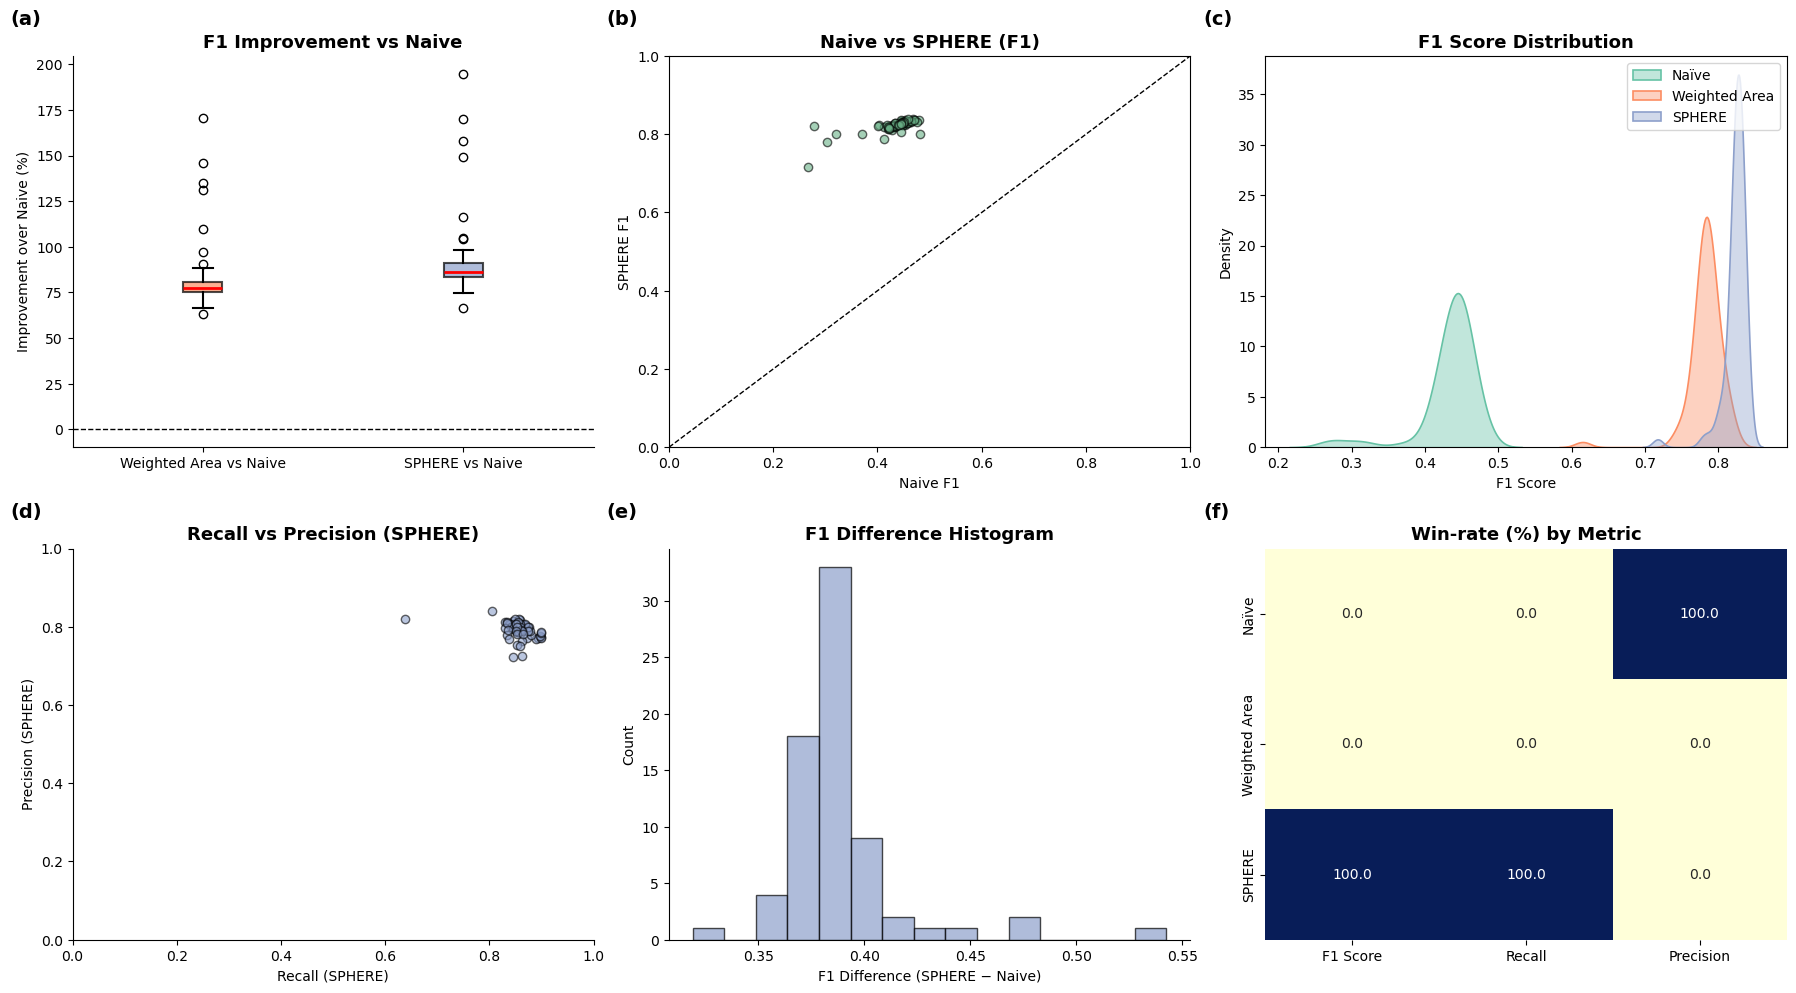

In [5]:
import seaborn as sns
plot_supplementary(df, "figure_supp_mousebrain_simu")